# Create the Original Dataset (to be readable)

In [42]:
#TODO: make this nicer
path = "data\\tox21_original\\tox21.sdf"

from rdkit import Chem
import pandas as pd
data_molecules = Chem.SDMolSupplier(path)

info_file = pd.read_csv("data\\tox21_original\\tox21_compoundData.csv", sep=",", header=0)

targets = info_file.to_numpy()[:, -12:]
ids = info_file["ID"].to_numpy()
to_del = []
with open("file.csv", mode = "w") as fi:
    fi.write("NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles\n")

    for mol, target, i, infofile in zip(data_molecules, targets, ids, range(len(info_file))):
        try:
            smiles = Chem.MolToSmiles(mol)
            #fi.write(",".join([str(int(t)) if str(t)!="nan" else "" for t in target]) + "," + i + "," + smiles + "\n")
        except BaseException:
            to_del.append(infofile)


# Initial Graph Attemt

In [221]:
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.nn.inits import glorot, zeros




class GATConv(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},

    where the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
        \right)\right)}.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    _alpha: OptTensor

    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, heads: int = 1, concat: bool = True,
                 negative_slope: float = 0.2, dropout: float = 0.0,
                 add_self_loops: bool = True, bias: bool = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(GATConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        if isinstance(in_channels, int):
            self.lin_l = Linear(in_channels, heads * out_channels, bias=False)
            self.lin_r = self.lin_l
        else:
            self.lin_l = Linear(in_channels[0], heads * out_channels, False)
            self.lin_r = Linear(in_channels[1], heads * out_channels, False)

        self.att_l = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = Parameter(torch.Tensor(1, heads, out_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin_l.weight)
        glorot(self.lin_r.weight)
        glorot(self.att_l)
        glorot(self.att_r)
        zeros(self.bias)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None, return_attention_weights=None):
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        #pdb.set_trace()

        x_l: OptTensor = None
        x_r: OptTensor = None
        alpha_l: OptTensor = None
        alpha_r: OptTensor = None
        if isinstance(x, Tensor):
            assert x.dim() == 2, 'Static graphs not supported in `GATConv`.'
            x_l = x_r = self.lin_l(x).view(-1, H, C)
            alpha_l = (x_l * self.att_l).sum(dim=-1)
            alpha_r = (x_r * self.att_r).sum(dim=-1)
        else:
            x_l, x_r = x[0], x[1]
            assert x[0].dim() == 2, 'Static graphs not supported in `GATConv`.'
            x_l = self.lin_l(x_l).view(-1, H, C)
            alpha_l = (x_l * self.att_l).sum(dim=-1)
            if x_r is not None:
                x_r = self.lin_r(x_r).view(-1, H, C)
                alpha_r = (x_r * self.att_r).sum(dim=-1)

        assert x_l is not None
        assert alpha_l is not None

        #Self loops might be that nodes are also connected to themselfes
        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                num_nodes = x_l.size(0)
                if x_r is not None:
                    num_nodes = min(num_nodes, x_r.size(0))
                if size is not None:
                    num_nodes = min(size[0], size[1])
                edge_index, _ = remove_self_loops(edge_index)
                edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                edge_index = set_diag(edge_index)

        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor)
        print("x_l:\n",x_l)
        print("x_r:\n",x_r)
        print("alpha_l:\n",alpha_l)
        print("alpha_r:\n", alpha_r)
        print("size:\n",size)
        print("edge_index:\n", edge_index)
        out = self.propagate(edge_index, x=(x_l, x_r),
                             alpha=(alpha_l, alpha_r), size=size)

        alpha = self._alpha
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out += self.bias

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor,
                edge_index_i: Tensor, edge_index_j: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        """Attention construction

        For the Sinkhorn-Knoff implementation the reparametization trick is used to keep differentiablity

        edge_index_i: Tensor
            The receiving edges of the messages
        edge_index_j: Tensor
            The sourcing edges of the messages
        """
        #index: contains the index where each x_j and alpha goes to (where the message is sent to)
        #We now need also where the message comes from to make the matrix double stochastic! (need to add it)
        #This is contained in the edge_index matrix
        
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, edge_index_i, ptr, size_i)
        self._alpha = alpha
        #alpha = F.dropout(alpha, p=self.dropout, training=self.training) #for now no dropout
        print("alpha:\n", alpha)

        print("alpha_shape:\n",alpha.shape)
        print("x_j:\n",x_j)
        print("x_j shape", x_j.shape)
        print("edge_index_i:\n", edge_index_i)
        print("ptr\n",ptr)
        print("size_i\n",size_i)
        print("edge_index_j:\n",edge_index_j)
        if True:
            z = torch.zeros((size_i, size_i))
            z[edge_index_j, edge_index_i] = alpha.squeeze()#maybe switch j and i here?
            sk = SinkhornKnopp()
            _ = sk.fit(z.detach().cpu().numpy())
            D1 = torch.tensor(sk._D1, dtype=torch.float32)
            D2 = torch.tensor(sk._D2, dtype=torch.float32)
            new_z = D1 @ z @ D2
            alpha = new_z[edge_index_j, edge_index_i]
            alpha = alpha.unsqueeze(-1)
            print("alpha_new:\n",alpha)
            #TODO: reparametize here
            print("z new:\n",new_z)

        return x_j * alpha.unsqueeze(-1)

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)

In [222]:
from typing import Optional, Callable, List
from torch_geometric.typing import Adj

import copy

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import ModuleList, Sequential, Linear, BatchNorm1d, ReLU

from torch_geometric.nn.models.jumping_knowledge import JumpingKnowledge

from utils.basic_modules import BasicGNN

class GAT(BasicGNN):
    r"""The Graph Neural Network from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper, using the
    :class:`~torch_geometric.nn.GATConv` operator for message passing.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        num_layers (int): Number of GNN layers.
        dropout (float, optional): Dropout probability. (default: :obj:`0.`)
        act (Callable, optional): The non-linear activation function to use.
            (default: :meth:`torch.nn.ReLU(inplace=True)`)
        norm (torch.nn.Module, optional): The normalization operator to use.
            (default: :obj:`None`)
        jk (str, optional): The Jumping Knowledge mode
            (:obj:`"last"`, :obj:`"cat"`, :obj:`"max"`, :obj:`"last"`).
            (default: :obj:`"last"`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.GATConv`.
    """
    def __init__(self, in_channels: int, hidden_channels: int, num_layers: int,
                 dropout: float = 0.0,
                 act: Optional[Callable] = ReLU(inplace=True),
                 norm: Optional[torch.nn.Module] = None, jk: str = 'last',
                 **kwargs):
        super().__init__(in_channels, hidden_channels, num_layers, dropout,
                         act, norm, jk)

        if 'concat' in kwargs:
            del kwargs['concat']

        if 'heads' in kwargs:
            assert hidden_channels % kwargs['heads'] == 0
        out_channels = hidden_channels // kwargs.get('heads', 1)

        self.convs.append(
            GATConv(in_channels, out_channels, dropout=dropout, **kwargs))
        for _ in range(1, num_layers):
            self.convs.append(GATConv(hidden_channels, out_channels, **kwargs))

In [227]:
gat = GAT(2, 3, 1, add_self_loops = True)

In [228]:
#data = torch.ones((5, 2))

In [229]:
#adj_data = torch.tensor([[1,2,3,1],[2,1,1,3]],dtype=torch.long)

In [230]:
gat(data, adj_data)

x_l:
 tensor([[[ 0.1211,  1.7863, -1.0226]],

        [[ 0.1211,  1.7863, -1.0226]],

        [[ 0.1211,  1.7863, -1.0226]],

        [[ 0.1211,  1.7863, -1.0226]],

        [[ 0.1211,  1.7863, -1.0226]]], grad_fn=<ViewBackward>)
x_r:
 tensor([[[ 0.1211,  1.7863, -1.0226]],

        [[ 0.1211,  1.7863, -1.0226]],

        [[ 0.1211,  1.7863, -1.0226]],

        [[ 0.1211,  1.7863, -1.0226]],

        [[ 0.1211,  1.7863, -1.0226]]], grad_fn=<ViewBackward>)
alpha_l:
 tensor([[-0.7814],
        [-0.7814],
        [-0.7814],
        [-0.7814],
        [-0.7814]], grad_fn=<SumBackward1>)
alpha_r:
 tensor([[0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232]], grad_fn=<SumBackward1>)
size:
 None
edge_index:
 tensor([[1, 2, 3, 1, 0, 1, 2, 3, 4],
        [2, 1, 1, 3, 0, 1, 2, 3, 4]])
alpha:
 tensor([[0.5000],
        [0.3333],
        [0.3333],
        [0.5000],
        [1.0000],
        [0.3333],
        [0.5000],
        [0.5000],
        [1.0000]], grad_fn=<Diffe

tensor([[0.1211, 1.7863, 0.0000],
        [0.1211, 1.7864, 0.0000],
        [0.1211, 1.7863, 0.0000],
        [0.1211, 1.7863, 0.0000],
        [0.1211, 1.7863, 0.0000]], grad_fn=<AsStridedBackward>)

# Try Sinkhorn

In [1]:
from main import main

In [2]:
main(name="new_train_logging5", architecture="gat", device = "cuda", epochs = 3)

Total number of Grid-Search configurations: 1728
Number of configurations now being trained 5
--------------------------------------------------------------------------------------------

Training config _hiddenchannels-64_headdepth-1_basedepth-10_basedropout-0.2_headdropout-0.2_lr-0.01_weightdecay-1e-08_batchsize-16 ... 

# Torchviz - Gradient Check

In [26]:
from torchviz import make_dot, make_dot_from_trace
import utils.baselines as baselines
import utils.data as data
from torch.utils.tensorboard import SummaryWriter


In [27]:
data_module = data.DataModule("tox21_original", split_mode = "predefined")


model = baselines.Sinkhorn_Baseline(
    data_module = data_module,
    n_hidden_channels = 64,
    n_graph_layers = 5, 
    n_graph_dropout = 0.5, 
    n_linear_layers = 2, 
    n_linear_dropout = 0.5
).to("cpu")

In [28]:
minibatch = data_module.train_loader.__iter__().__next__()
x, edge_index, batch = minibatch.x.float().to("cpu"), minibatch.edge_index.to("cpu"), minibatch.batch.to("cpu")

In [29]:
model.train()
first = model(x, edge_index, batch)[0]

In [30]:
import torch.nn.functional as F
import torch

In [31]:
r = F.binary_cross_entropy(first, torch.ones_like(first, dtype=torch.float32))

In [32]:
for p in model.named_parameters():
    p[1].grad = None

In [34]:
r.backward()

In [35]:
for p in model.named_parameters():
    print(p[0],p[1].grad)

sinkhorn_gat.convs.0.att_l tensor([[[-1.1798e-04,  1.0697e-04, -1.5574e-04, -4.9223e-04, -5.5028e-04,
          -3.0960e-04,  1.0956e-03,  4.3440e-04, -9.9472e-04,  1.2764e-03,
          -5.2822e-04,  1.5746e-03,  4.8859e-05, -8.5240e-04, -3.5370e-04,
          -1.7370e-04,  1.4068e-03,  1.4103e-03,  5.9372e-04, -3.8239e-05,
           2.1291e-04,  6.2977e-04,  6.6890e-05,  7.6267e-04, -4.0481e-04,
           2.6828e-04, -3.6096e-04,  3.6182e-04, -1.8373e-04,  2.3585e-04,
           3.4989e-04, -2.1231e-04,  4.5266e-04, -2.3610e-04,  6.7636e-04,
           1.5044e-04, -2.7506e-04,  8.5876e-04, -3.0125e-04,  4.9685e-05,
           9.2022e-05,  1.5521e-03,  8.1995e-05,  1.1723e-03, -4.3388e-04,
           3.1275e-04, -4.1699e-04, -3.5827e-04, -7.2029e-04, -4.0619e-04,
          -8.0981e-05,  8.6430e-04, -5.2576e-04,  1.2273e-03, -8.2231e-04,
           4.4406e-04, -4.4581e-04, -6.4301e-04,  1.0120e-03,  1.1081e-05,
           3.8480e-04, -5.8686e-06, -1.2454e-03, -1.5807e-03]]])
sinkhorn

In [18]:
writer = SummaryWriter('runs/test/test1_viz')

In [19]:
writer.add_graph(model, (x, edge_index, batch))

/mnt/92669E5D669E4241/OneHotGraph/utils/sinkhorn_graph.py:227: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if size is not None:
/mnt/92669E5D669E4241/OneHotGraph/utils/sinkhorn_graph.py:75: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  or torch.any(torch.sum(P_eps, dim=1) > max_thresh) \
/mnt/92669E5D669E4241/OneHotGraph/utils/sinkhorn_graph.py:287: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. Thi

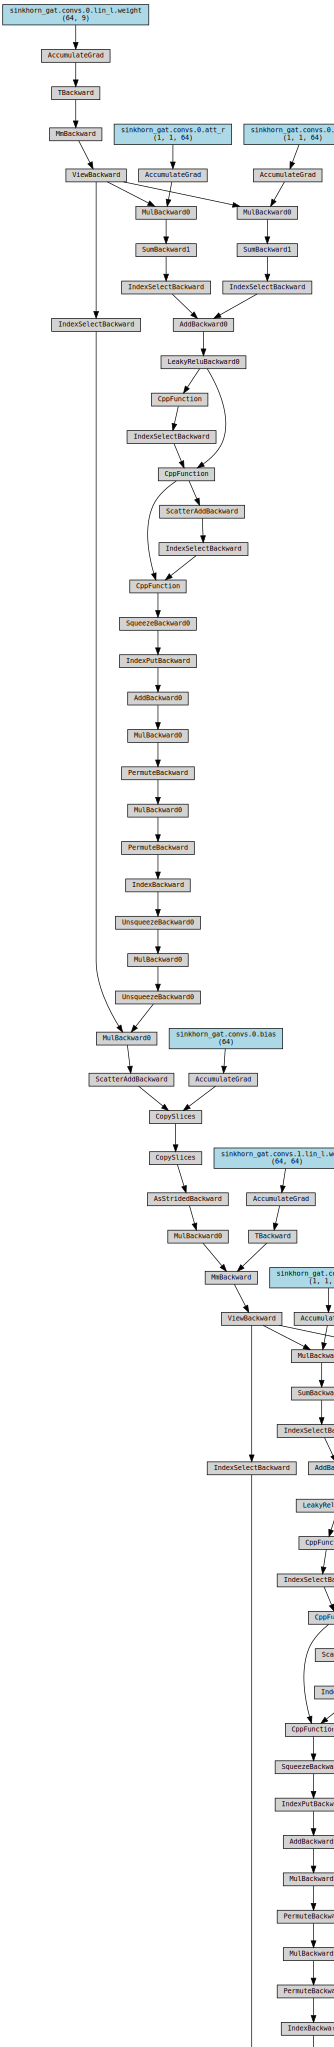

In [16]:
make_dot(model(x, edge_index, batch), params = dict(model.named_parameters())).render()

# Sinkhorn Pytorch

In [8]:
from torch import Tensor
import torch
import copy
import numpy as np

In [14]:
def sinkhorn(P: Tensor, threshhold = 1e-3, max_iter = 100):
    """Fit the diagonal matrices in Sinkhorn Knopp's algorithm

    Parameters
    ----------
    P : 2d Tensor

    Returns
    -------
    A double stochastic matrix.

    """

    N = P.shape[0]
    max_thresh = 1 + threshhold
    min_thresh = 1 - threshhold

    # Initialize r and c, the diagonals of D1 and D2
    r = torch.ones(N)
    pdotr = P.T @ r

    c = 1 / pdotr
    pdotc = P @ c


    r = 1 / pdotc
    del pdotr, pdotc
    P_eps = copy.copy(P)

    iterations = 0
    stopping_condition = None
    while torch.any(torch.sum(P_eps, dim=1) < min_thresh) \
            or torch.any(torch.sum(P_eps, dim=1) > max_thresh) \
            or torch.any(torch.sum(P_eps, dim=0) < min_thresh) \
            or torch.any(torch.sum(P_eps, dim=0) > max_thresh):

        c = 1 / (P.T @ r)
        r = 1 / (P @ c)

        P_eps = ((P * c).T * r).T

        iterations += 1

        if iterations >= max_iter:
            stopping_condition = "max_iter"
            break

    if not stopping_condition:
        stopping_condition = "epsilon"


    P_eps = ((P * c).T * r).T


    return P_eps, r, c, stopping_condition

In [41]:
ten = torch.from_numpy(np.random.uniform(0.1, 1, (3,3))).float()
ten[0,1] = 0

In [42]:
tw = torch.sparse_coo_tensor(indices = torch.tensor([[0,1,1,2], [0, 1, 2, 2]]), values = torch.tensor([0.1,0.5,0.7,0.9]))._to_sparse_csr()
tw.to_dense()

tensor([[0.1000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.7000],
        [0.0000, 0.0000, 0.9000]])

In [43]:
P_eps, r, c, stopping_condition = sinkhorn(ten)

In [44]:
ten

tensor([[0.2122, 0.0000, 0.1146],
        [0.2251, 0.4715, 0.6519],
        [0.2245, 0.2173, 0.7087]])

In [45]:
P_eps

tensor([[0.7041, 0.0000, 0.2959],
        [0.1223, 0.6022, 0.2755],
        [0.1745, 0.3970, 0.4285]])

In [31]:
stopping_condition

'epsilon'